In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/diganes')
sys.path.append('/content/drive/My Drive/diganes/code')

In [1]:
import pandas as pd
from torchvision import transforms
import torchvision
import torchsummary
import numpy as np
from code.diganes_dataset import DiganesDataset
from code.MyPytorchModel import MyPytorchModel
from code.transformations import RandomPermutation, ReverseTransform
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from PIL import Image
import pickle
from sklearn.metrics import classification_report

%load_ext autoreload
%autoreload 2

## Load dataset and checkout transformation

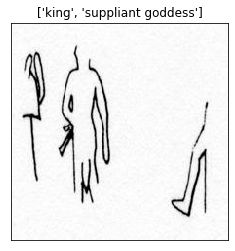

In [33]:
label_file = '/Users/atad/Desktop/DIGANES/diganes/diganens.csv'
pic_dir = '/Users/atad/Desktop/DIGANES/resized_pics'
diganes = DiganesDataset(label_file, pic_dir, category='drawing', min_label_count=50)

image, labels = diganes[222]
diganes.show_image(image, labels)

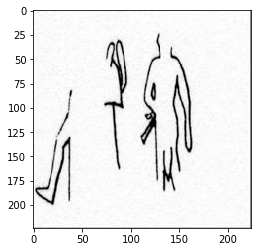

In [34]:
transform = RandomPermutation(cache_dir=pic_dir)
per = transform(image)
plt.imshow(per)

In [35]:
transform = transforms.Compose(
    [RandomPermutation(cache_dir=pic_dir),
     #transforms.Resize((224, 224)),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(), 
     transforms.Normalize(mean=[0.49191375, 0.48235852, 0.44673872], 
                          std=[0.24706447, 0.24346213, 0.26147554])])

reverse_transform = ReverseTransform(mean=[0.49191375, 0.48235852, 0.44673872],
                                     std=[0.24706447, 0.24346213, 0.26147554])

dataset = DiganesDataset(label_file, pic_dir, category='drawing', min_label_count=50, 
                         transform=transform, reverse_transform=reverse_transform)

In [36]:
# load the pretrained model
pretrained_model = torchvision.models.mobilenet_v2(pretrained=True)

# features
print('Conv feature extractor:')
print(pretrained_model.features)
# classifier
print('Classification head:')
print(pretrained_model.classifier)

Conv feature extractor:
Sequential(
  (0): ConvBNReLU(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (1): InvertedResidual(
    (conv): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): InvertedResidual(
    (conv): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Re

In [37]:
feature_extractor = pretrained_model.features

torchsummary.summary(feature_extractor, (3, 224, 224), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Using device:', device)

Using device: cpu


In [40]:
# Feel free to change the hyperparameters here!
hparams = {
    "batch_size": 64,
    "lr": 3e-4,
    "layers_to_freeze": 10
}

#set seed so split to datasets is reproducible
torch.manual_seed(32)
model = MyPytorchModel(hparams, dataset, torchvision.models.mobilenet_v2(pretrained=True))
model.to(device)

MyPytorchModel(
  (model): PretrainedClassifier(
    (feature_extractor): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(16, 96, kernel_size=(1, 1), strid

In [ ]:
trainer = None

early_stop_callback = EarlyStopping(
   monitor='val_loss',
   patience=5,
   verbose=True,
   mode='min'
)

trainer = pl.Trainer(
    max_epochs=20,
    early_stop_callback=early_stop_callback,
    gpus=1 if torch.cuda.is_available() else None
)

trainer.fit(model)

GPU available: False, used: False
No environment variable for node rank defined. Set as 0.

    | Name                                | Type                 | Params
-------------------------------------------------------------------------
0   | model                               | PretrainedClassifier | 2 M   
1   | model.feature_extractor             | Sequential           | 2 M   
2   | model.feature_extractor.0           | ConvBNReLU           | 928   
3   | model.feature_extractor.0.0         | Conv2d               | 864   
4   | model.feature_extractor.0.1         | BatchNorm2d          | 64    
5   | model.feature_extractor.0.2         | ReLU6                | 0     
6   | model.feature_extractor.1           | InvertedResidual     | 896   
7   | model.feature_extractor.1.conv      | Sequential           | 896   
8   | model.feature_extractor.1.conv.0    | ConvBNReLU           | 352   
9   | model.feature_extractor.1.conv.0.0  | Conv2d               | 288   
10  | model.feature_

Val-F1=0.18, Val-Loss:0.74


In [32]:
f_score, scores, labels = model.getDataloaderF1()
print("F-1 Score: ", f_score)

F-1 Score:  0.40035911430523086


In [27]:
print("Classification report: \n", (classification_report(labels, scores, zero_division=0)))

Classification report: 
               precision    recall  f1-score   support

           0       0.67      0.44      0.53        18
           1       0.67      0.40      0.50         5
           2       0.80      0.36      0.50        11
           3       0.00      0.00      0.00         4
           4       0.56      0.50      0.53        18
           5       1.00      0.62      0.77        16
           6       1.00      0.14      0.25         7
           7       1.00      0.20      0.33         5
           8       0.00      0.00      0.00         4
           9       0.46      0.32      0.37        19
          10       0.50      0.43      0.46        30
          11       0.00      0.00      0.00         8
          12       0.59      0.62      0.60        26
          13       0.95      0.91      0.93        82
          14       0.50      0.14      0.22         7
          15       0.61      0.59      0.60        37
          16       0.50      0.45      0.48        11
  

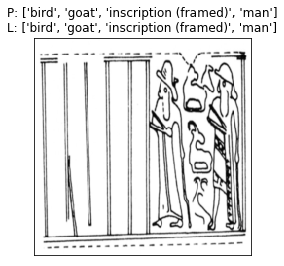

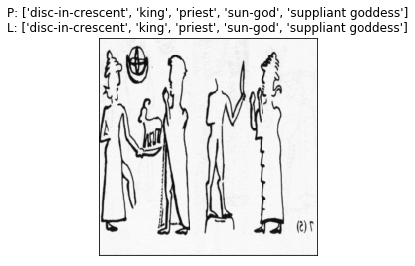

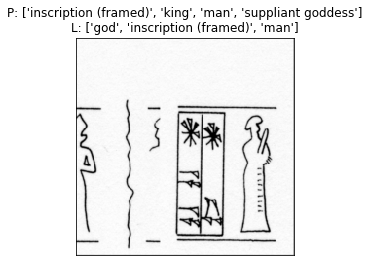

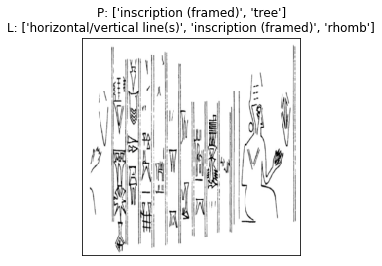

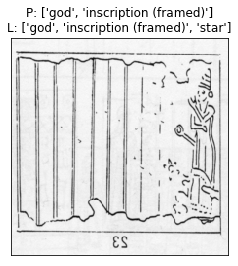

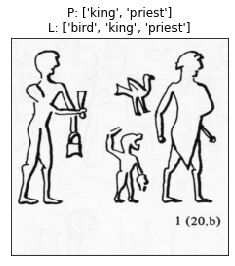

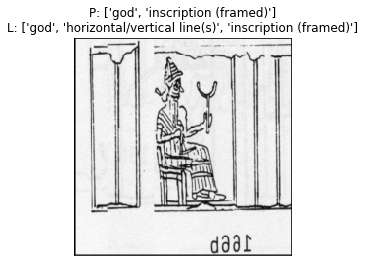

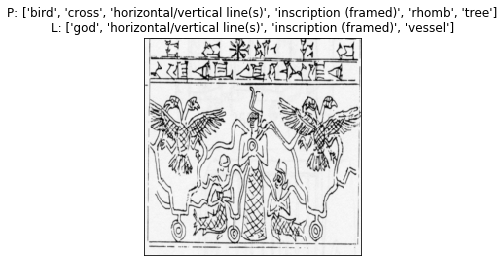

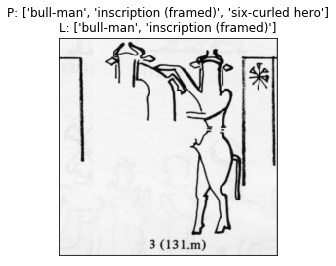

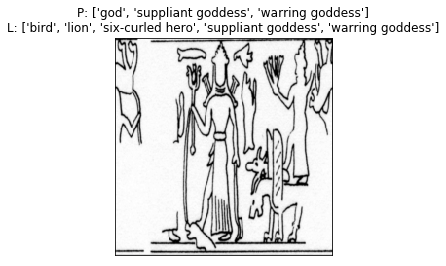

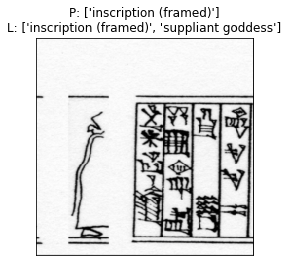

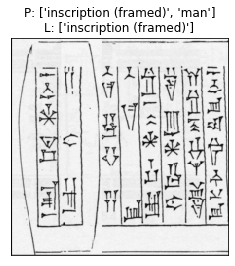

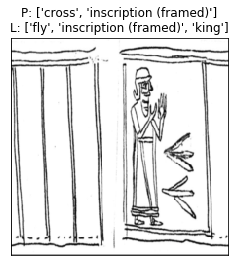

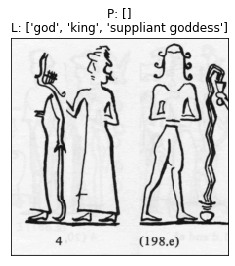

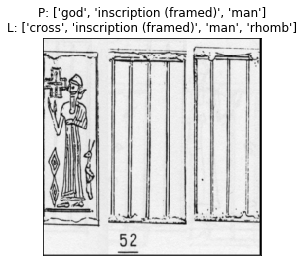

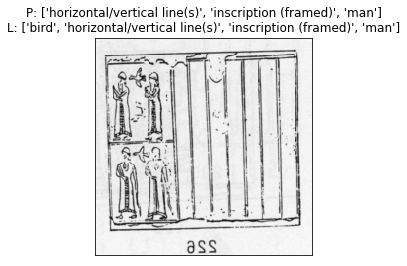

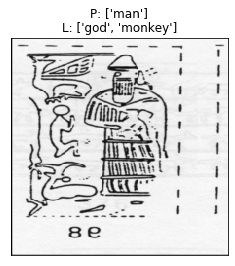

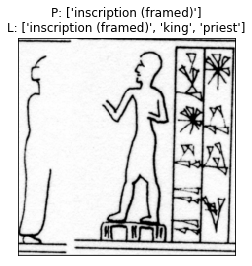

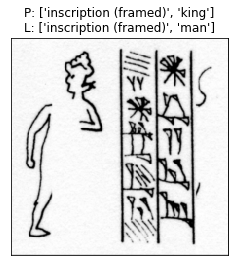

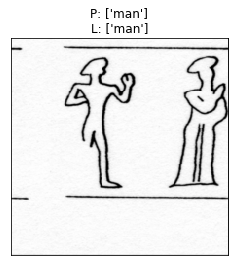

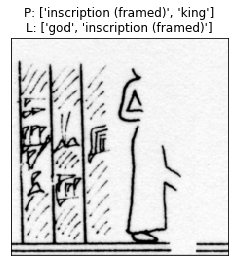

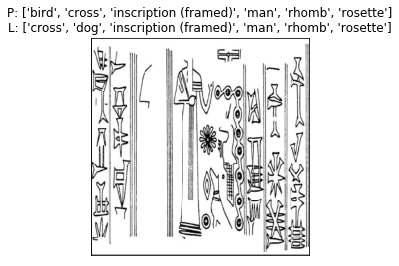

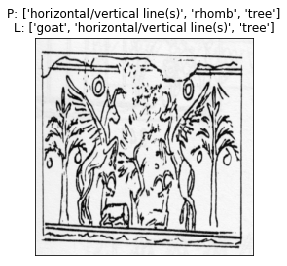

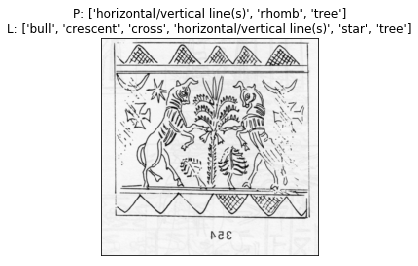

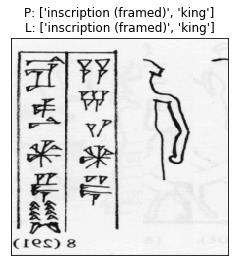

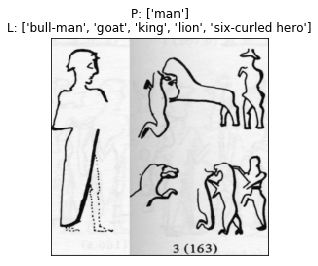

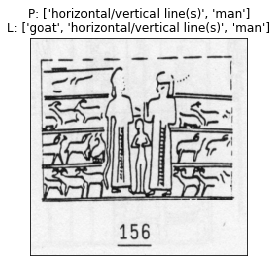

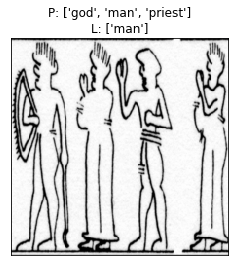

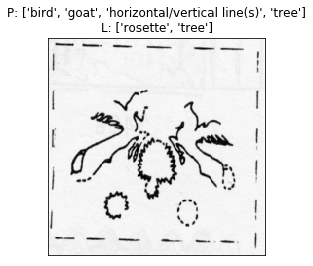

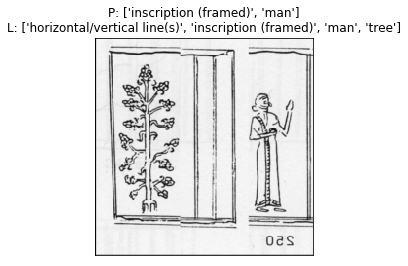

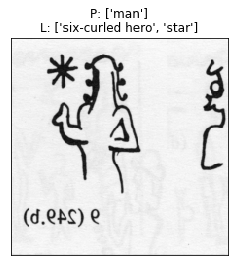

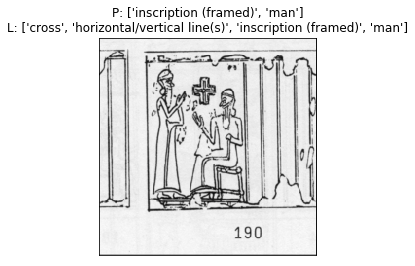

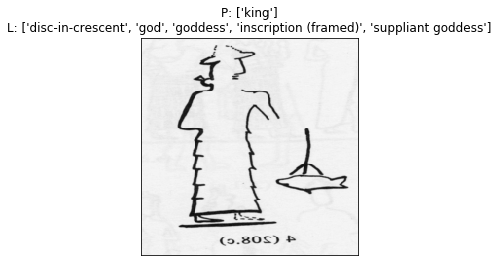

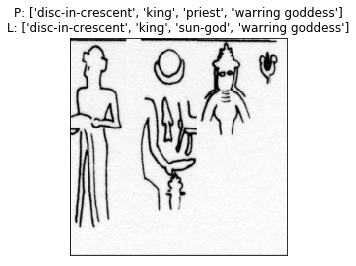

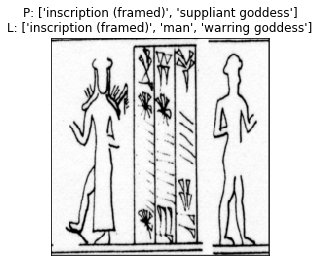

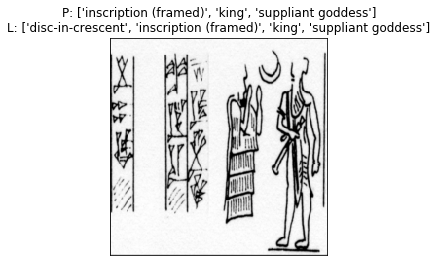

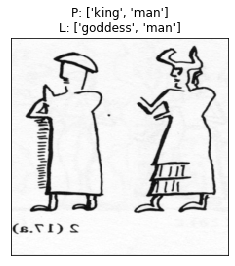

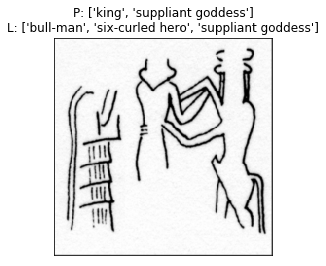

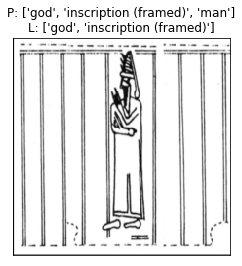

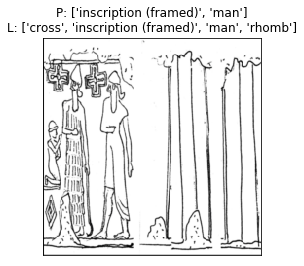

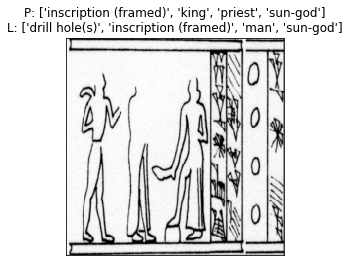

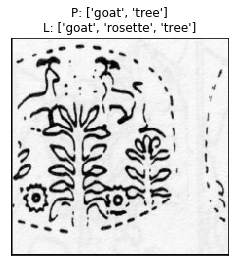

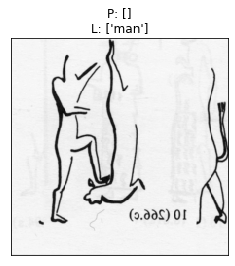

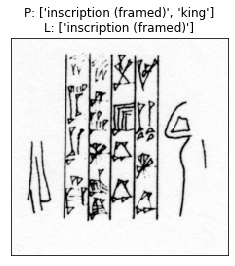

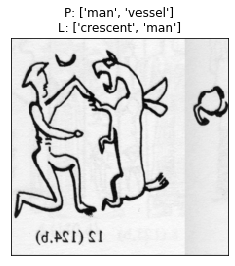

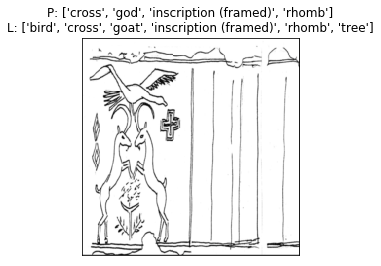

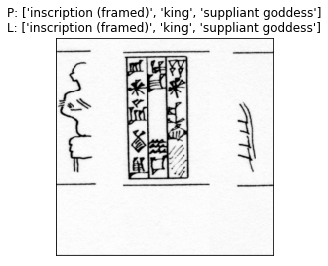

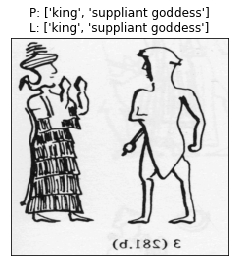

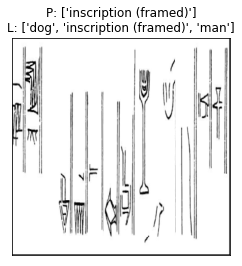

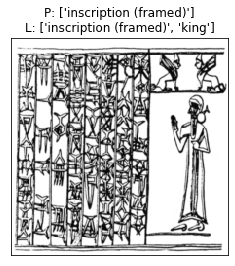

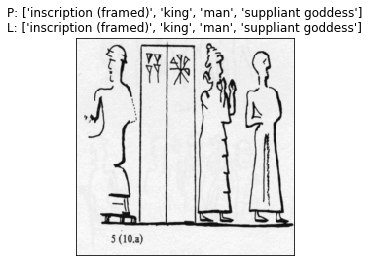

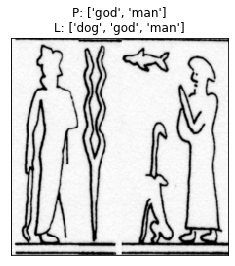

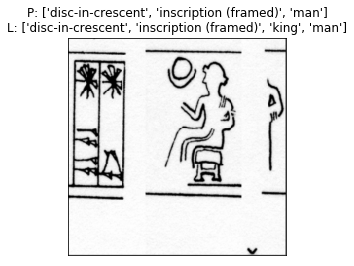

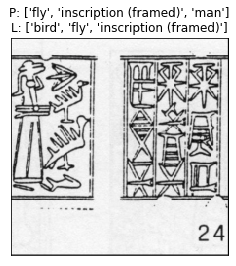

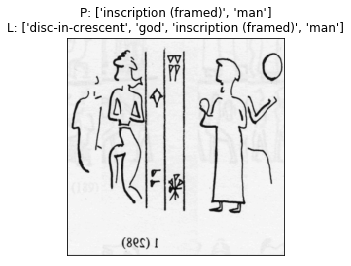

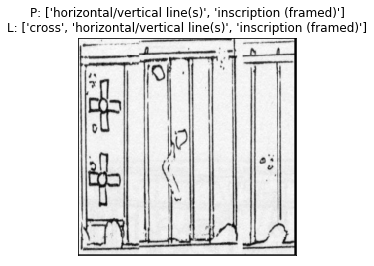

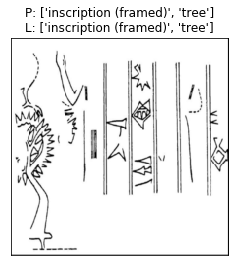

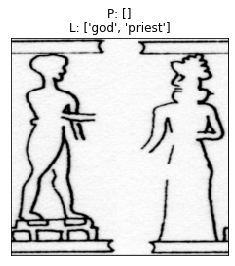

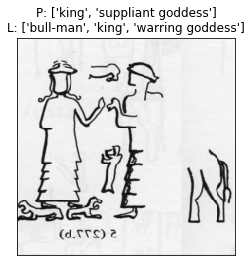

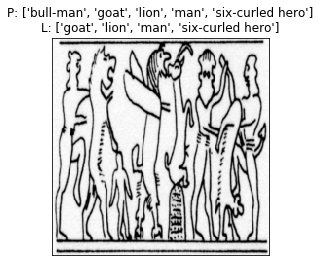

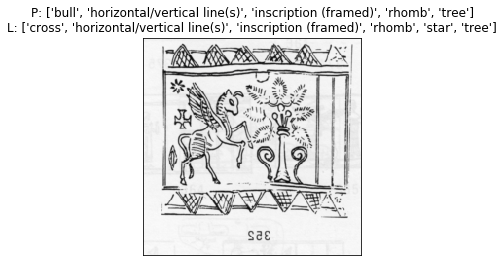

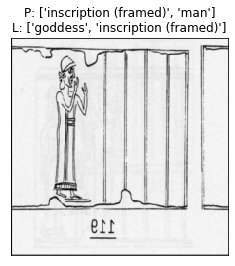

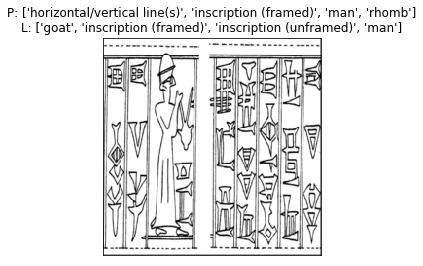

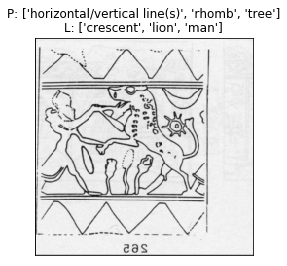

In [28]:
%matplotlib inline
model.model.eval()

for batch in model.val_dataloader():
    X, y = batch
    out = model.forward(X)
    preds = (out.data > 0.5).float()
    
    for i in range(X.shape[0]):
        image = X[i,:,:,:].squeeze()
        labels = y[i,:].squeeze()
        pred = preds[i,:].squeeze()
        
        dataset.show_image(image, labels, pred)
    break


In [ ]:
model.eval()
image = Image.open('test3.jpg')
image = transform(image)
X = image.reshape((1, 3, 224, 224))

score = model.forward(X)
preds = (torch.sigmoid(score).data > 0.5).float()
dataset.show_image(image, preds[0])

In [ ]:
torch.save(model, "mobilenet_v2_model.pt")
